# Calibration w.r.t. the soft labels

In [6]:
import os
from datasets import load_from_disk
import numpy as np

# sciq
# w2s_path = "../results/function-grads/sciq/bs=64-dl=1-dn=sciq-e=1-ee=25-gib=1-lp=0-lbmae=0-l=kl-l=0.0015-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Mistral-7B-v0.1-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=1-s=0-sg=1-twd=0-wms=Qwen1.5-0.5B"
# strong_path = "../results/function-grads/sciq/bs=32-dl=1-dn=sciq-e=5-ee=10000000-gib=1-lp=0-lbmae=0-l=xent-l=0.003-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Mistral-7B-v0.1-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=1-s=0-sg=0-twd=0"
# weak_path = "../results/function-grads/sciq/bs=32-dl=1-dn=sciq-e=5-ee=10000000-gib=1-lp=0-lbmae=0-l=xent-l=0.003-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Qwen1.5-0.5B-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=1-s=0-sg=0-twd=0"

# sciq with support
w2s_path = "../results/function-grads/bs=64-dl=1-dn=sciq_with_supp-e=10-ee=25-gib=1-lp=0-lbmae=0-l=kl-l=8.999999999999999e-05-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Qwen1.5-0.5B-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=50-s=0-sg=1-twd=0-wms=opt-350m"
# w2s_path = "../results/function-grads/bs=64-dl=1-dn=sciq_with_supp-e=2-ee=25-gib=1-lp=0-lbmae=0-l=kl-l=0.00030000000000000003-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Qwen1.5-0.5B-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=50-s=0-sg=1-twd=0-wms=opt-350m"
# w2s_path = "../results/function-grads/bs=64-dl=1-dn=sciq_with_supp-e=2-ee=25-gib=1-lp=0-lbmae=0-l=kl-l=0.003-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Qwen1.5-0.5B-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=50-s=0-sg=1-twd=0-wms=opt-350m"
strong_path = "../results/function-grads/bs=32-dl=1-dn=sciq_with_supp-e=5-ee=10000000-gib=1-lp=0-lbmae=0-l=xent-l=0.003-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Qwen1.5-0.5B-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=50-s=0-sg=0-twd=0"
weak_path = "../results/function-grads/bs=32-dl=1-dn=sciq_with_supp-e=5-ee=10000000-gib=1-lp=0-lbmae=0-l=xent-l=0.003-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=opt-350m-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=50-s=0-sg=0-twd=0"

eval_results_paths = [p for p in os.listdir(w2s_path) if p.startswith("eval_results") and p[-1].isdigit()]
eval_results_paths.sort(key=lambda x: int(x.split("_")[-1]))

weak_soft_labels = None
gt_labels = None
pred_probs = []
for p in eval_results_paths:
    eval_results = load_from_disk(os.path.join(w2s_path, p)).with_format("numpy")
    if weak_soft_labels is None:
        weak_soft_labels = eval_results['weak_soft_label'][:, 1]  # type: ignore
    else:
        assert np.all(weak_soft_labels == eval_results['weak_soft_label'][:, 1])  # type: ignore
    if gt_labels is None:
        gt_labels = eval_results['soft_label'][:, 1]  # type: ignore
    else:
        assert np.all(gt_labels == eval_results['soft_label'][:, 1])  # type: ignore
    pred_probs.append(eval_results['soft_pred'][:, 1])  # type: ignore

weak_soft_labels = np.array(weak_soft_labels)
pred_probs = np.array(pred_probs)
gt_labels = np.array(gt_labels)
weak_soft_labels.shape, pred_probs.shape, gt_labels.shape

((264,), (25, 264), (264,))

In [8]:
import plotly.graph_objs as go
import numpy as np

n_time_steps = len(pred_probs)
# Create base figure
fig = go.Figure(
    data=[go.Scatter(x=pred_probs[0], y=weak_soft_labels, mode='markers',  
                     marker=dict(color=gt_labels, colorscale='Viridis', colorbar=dict(title='GT Label (t=0)')))],
    layout=go.Layout(
        title="Soft Labels Over Time",
        xaxis=dict(range=[0, 1], title="Strong student predicted probability"),
        yaxis=dict(range=[0, 1], title="Weak supervisor soft label"),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 700, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause",
                         method="animate",
                         args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
                    ])]
    ),
    frames=[go.Frame(data=[go.Scatter(x=pred_probs[i], y=weak_soft_labels, mode='markers',
                                        marker=dict(color=gt_labels, colorscale='Viridis', colorbar=dict(title=f'GT Label (t={i})')))],
                         name=str(i))
            for i in range(1, n_time_steps)]
)

# Add axis titles
fig.update_layout(xaxis_title="Strong student predicted probability", yaxis_title="Weak supervisor soft label", height=800, width=900)


# Show animation
fig.show()

# Validate linear approximation of effect of train examples on model behavior

Step 85 has different number of ids and expected effects 56 vs 64
Step 171 has different number of ids and expected effects 56 vs 64
Step 257 has different number of ids and expected effects 56 vs 64
Step 343 has different number of ids and expected effects 56 vs 64
Step 429 has different number of ids and expected effects 56 vs 64


Text(0.5, 1.0, "When linearly approximating effect on model's eval *logodds* over 450 SGD steps")

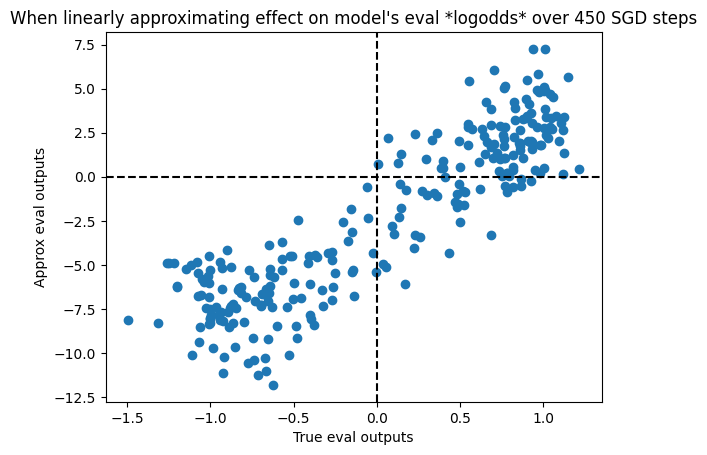

In [12]:
import torch
num_steps = 450 # max(int(p.split("_")[-1][:-3]) for p in os.listdir(w2s_path) if p.startswith("gradients")) + 1

key = "eval_outputs"
# key = "eval_probs"
initial_eval_outputs = None
approx_eval_outputs = None
last_eval_outputs = None
eval_outputs = []
examplewise_expected_effects = []
grads_ids = []

# TODO: check that ids are the same
for step in range(num_steps):
    grads_dict = torch.load(f"{w2s_path}/gradients_{step}.pt", map_location="cpu")
    if initial_eval_outputs is None or approx_eval_outputs is None:
        initial_eval_outputs = grads_dict[key]
        approx_eval_outputs = grads_dict[key]

    last_eval_outputs = grads_dict[key]
    eval_outputs.append(last_eval_outputs.repeat((len(grads_dict["ids"]), 1)))
    # NOTE: due to a bug some of the expected effects had unmodified rows from torch.empty, so
    # we remove them here
    expected_effects = grads_dict["expected_effects"][:len(grads_dict["ids"])]
    approx_eval_outputs = approx_eval_outputs.add(expected_effects.sum(dim=0))
    examplewise_expected_effects.append(expected_effects)
    grads_ids.extend(grads_dict["ids"])

    if len(grads_dict["ids"]) != len(grads_dict["expected_effects"]):
        print(f"Step {step} has different number of ids and expected effects {len(grads_dict['ids'])} vs {len(grads_dict['expected_effects'])}")

eval_outputs = torch.cat(eval_outputs, dim=0)  # [n_train, n_eval]
examplewise_expected_effects = torch.cat(examplewise_expected_effects, dim=0)  # [n_train, n_eval]

import matplotlib.pyplot as plt
plt.scatter(last_eval_outputs, approx_eval_outputs)
plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("True eval outputs")
plt.ylabel("Approx eval outputs")
plt.title(f"When linearly approximating effect on model's eval *logodds* over {num_steps} SGD steps")

In [13]:
train_ds = load_from_disk(os.path.join(w2s_path, "train_ds")).with_format("numpy")
n_train, n_eval = examplewise_expected_effects.shape
gt_hard_labels = train_ds["gt_hard_label"][:n_train]
weak_soft_labels = train_ds["soft_label"][:n_train, 1]
ids = train_ds["id"][:n_train]
if len(gt_hard_labels) < n_train:
    gt_hard_labels = np.concatenate([gt_hard_labels] * (n_train // len(gt_hard_labels) + 1))[:n_train]
    weak_soft_labels = np.concatenate([weak_soft_labels] * (n_train // len(weak_soft_labels) + 1))[:n_train]
    ids = np.concatenate([ids] * (n_train // len(ids) + 1))[:n_train]
weak_error = weak_soft_labels - gt_hard_labels

In [14]:
w2s_eval_ds = load_from_disk(os.path.join(w2s_path, f"eval_results_{num_steps - num_steps % 25}")).with_format("numpy")
strong_eval_ds = load_from_disk(os.path.join(strong_path, "eval_results_final")).with_format("numpy")
weak_eval_ds = load_from_disk(os.path.join(weak_path, "eval_results_final")).with_format("numpy")
eval_gt_hard_labels = w2s_eval_ds["hard_label"]
strong_eval_logodds = strong_eval_ds["logit"][:, 1] - strong_eval_ds["logit"][:, 0]
weak_eval_logodds = weak_eval_ds["logit"][:, 1] - weak_eval_ds["logit"][:, 0]
w2s_eval_logodds = w2s_eval_ds["logit"][:, 1] - w2s_eval_ds["logit"][:, 0]

In [22]:
from concept_erasure import LeaceEraser
from typing import Literal

def erase_labels(x, soft_labels, label_erasure: Literal["none", "leace", "mean-diff", "keep-negative", "keep-positive"] = "none"):
    mask = np.full_like(soft_labels, True, dtype=bool)
    if label_erasure == "leace":
        eraser = LeaceEraser.fit(x=x, z=torch.from_numpy(soft_labels > 0.5))
        erased = eraser(x=x)
    elif label_erasure == "mean-diff":
        pos_mean = (x * soft_labels[:, None]).mean(dim=0)
        neg_mean = (x * (1 - soft_labels)[:, None]).mean(dim=0)
        mean_diff = pos_mean - neg_mean
        mean_diff = mean_diff / mean_diff.norm()
        erased = x - x @ mean_diff[:, None] * mean_diff[None, :] / (mean_diff @ mean_diff)
    elif label_erasure == "keep-negative":
        mask = soft_labels < 0.5
        erased = x[mask]
    elif label_erasure == "keep-positive":
        mask = soft_labels > 0.5
        erased = x[mask]
    elif label_erasure == "none":
        erased = x
    else:
        raise ValueError(f"Unknown label erasure method {label_erasure}")
    return erased, mask

In [21]:
mask

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

Explained variance ratio: [0.9821257  0.00930016]
AUROC of y axis 0.7202457266890172
Explained variance ratio: [0.9821257  0.00930016]
AUROC of y axis 0.7708544673594518


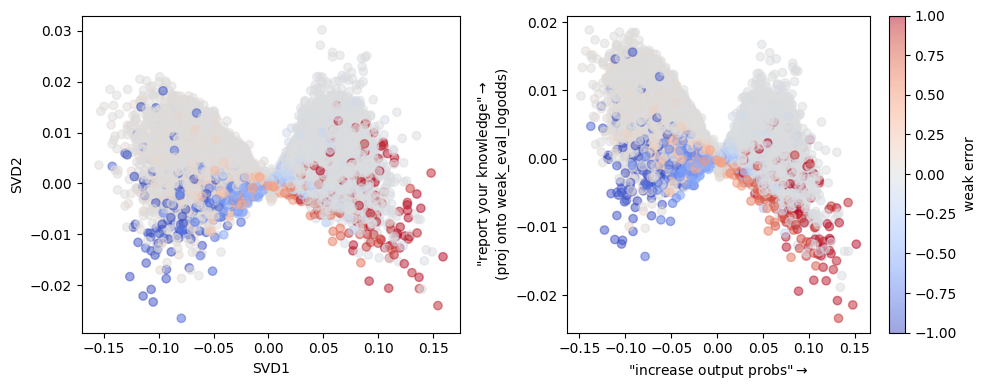

In [23]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import roc_auc_score
import seaborn as sns

weak_label_erased, mask = erase_labels(examplewise_expected_effects, weak_soft_labels, label_erasure="none")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
svd = TruncatedSVD(n_components=2)
examplewise_expected_effects_reduced = svd.fit_transform(weak_label_erased)
plt.scatter(examplewise_expected_effects_reduced[:, 0], examplewise_expected_effects_reduced[:, 1], c=weak_error[mask], cmap="coolwarm", alpha=0.5, vmin=-1, vmax=1)
plt.xlabel("SVD1")
plt.ylabel("SVD2")

print(f"Explained variance ratio: {svd.explained_variance_ratio_}")
print(f"AUROC of y axis {roc_auc_score(np.abs(weak_error[mask]) < 0.5, examplewise_expected_effects_reduced[:, 1])}")

from copy import deepcopy
custom_proj = deepcopy(svd)
custom_proj.components_[0] = np.ones(n_eval) / np.sqrt(n_eval)
# yaxis_name = "eval_gt_hard_labels"
yaxis_name = "weak_eval_logodds"
yaxis = locals()[yaxis_name] - np.mean(locals()[yaxis_name])
custom_proj.components_[1] = yaxis / np.linalg.norm(yaxis)
examplewise_expected_effects_reduced = custom_proj.transform(weak_label_erased)

plt.subplot(1, 2, 2)
plt.scatter(examplewise_expected_effects_reduced[:, 0], examplewise_expected_effects_reduced[:, 1], c=weak_error[mask], cmap="coolwarm", alpha=0.5, vmin=-1, vmax=1)
# plt.xlim(-0.2, 0.2)
# plt.ylim(-0.02, 0.02)
plt.colorbar(label="weak error")
plt.xlabel("\"increase output probs\"$\\to$")
plt.ylabel(f"\"report your knowledge\"$\\to$\n(proj onto {yaxis_name})")
plt.tight_layout()

print(f"Explained variance ratio: {custom_proj.explained_variance_ratio_}")
print(f"AUROC of y axis {roc_auc_score(np.abs(weak_error[mask]) < 0.5, examplewise_expected_effects_reduced[:, 1])}")
plt.show()


L2 norm of average incorrect effect: 0.0029327699448913336
L2 norm of average correct effect: 0.0003453291719779372
Incorrect avg kl: (0.00 +/- 0.00) * 10^-4.0
Correct avg kl: (0.00 +/- 0.00) * 10^-4.0


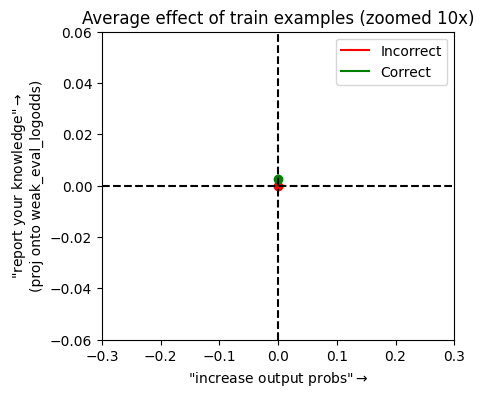

In [24]:
from torch.nn.functional import sigmoid, logsigmoid

label_erasure = "mean-diff"
weak_label_erased, mask = erase_labels(examplewise_expected_effects, weak_soft_labels, label_erasure=label_erasure)
### size of average effect ###
correct_avg_effect = weak_label_erased[np.abs(weak_error) < 0.1].mean(dim=0)
incorrect_avg_effect = weak_label_erased[np.abs(weak_error) > 0.9].mean(dim=0)

print(f"L2 norm of average incorrect effect: {correct_avg_effect.norm().item()}")
print(f"L2 norm of average correct effect: {incorrect_avg_effect.norm().item()}")

### average size of effect ###
# elementwise kl divergence
# p0 * (log(p0) - log(p1)) + (1 - p0) * (log(1 - p0) - log(1 - p1))
kl = sigmoid(eval_outputs) * (logsigmoid(eval_outputs) - logsigmoid(eval_outputs + weak_label_erased)) + \
        sigmoid(-eval_outputs) * (logsigmoid(-eval_outputs) - logsigmoid(-eval_outputs - weak_label_erased))
kl = kl.mean(dim=1)

if label_erasure == "none":
    print("WARNING: norm measurements are not meaningful when label erasure is not applied")
correct_norms = kl[np.abs(weak_error) < 0.1]
incorrect_norms = kl[np.abs(weak_error) > 0.9]
correct_avg_norm = correct_norms.mean()
incorrect_avg_norm = incorrect_norms.mean()
correct_sem_norm = correct_norms.std() / np.sqrt(len(correct_norms))
incorrect_sem_norm = incorrect_norms.std() / np.sqrt(len(incorrect_norms))
print_scale = 1e4
print(f"Incorrect avg kl: ({print_scale * incorrect_avg_norm:.2f} +/- {print_scale * 2 * incorrect_sem_norm:.2f}) * 10^{-np.log10(print_scale)}")
print(f"Correct avg kl: ({print_scale * correct_avg_norm:.2f} +/- {print_scale * 2 * correct_sem_norm:.2f}) * 10^{-np.log10(print_scale)}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
proj = custom_proj
incorrect_2d = proj.transform(incorrect_avg_effect[None, :])
correct_2d = proj.transform(correct_avg_effect[None, :])

plt.plot([0, incorrect_2d[0, 0]], [0, incorrect_2d[0, 1]], label="Incorrect", color="red")
plt.plot([0, correct_2d[0, 0]], [0, correct_2d[0, 1]], label="Correct", color="green")
plt.scatter(incorrect_2d[0, 0], incorrect_2d[0, 1], color="red")
plt.scatter(correct_2d[0, 0], correct_2d[0, 1], color="green")
zoom = 10
plt.xlim(-3 / zoom, 3 / zoom)
plt.ylim(-0.6 / zoom, 0.6 / zoom)

if proj is svd:
    plt.xlabel("SVD1")
    plt.ylabel("SVD2")
elif proj is custom_proj:
    plt.xlabel("\"increase output probs\"$\\to$")
    plt.ylabel(f"\"report your knowledge\"$\\to$\n(proj onto {yaxis_name})")
else:
    raise ValueError(f"Unknown projection {proj}")

plt.title(f"Average effect of train examples (zoomed {zoom}x)")
plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.legend()
plt.show()

In [26]:
from sklearn.linear_model import LogisticRegression

label_erasure = "none"
weak_label_erased, mask = erase_labels(examplewise_expected_effects, weak_soft_labels, label_erasure=label_erasure)
is_correct = np.abs(weak_error[mask]) < 0.5

probe_type = "weak_eval_proj"
if probe_type == "svd2":
    probe = svd.components_[1]
elif probe_type == "gt_eval_proj":
    probe = eval_gt_hard_labels - np.mean(eval_gt_hard_labels)
    probe = probe / np.linalg.norm(probe)
elif probe_type == "weak_eval_proj":
    probe = weak_eval_logodds - np.mean(weak_eval_logodds)
    probe = probe / np.linalg.norm(probe)
elif probe_type == "strong_eval_proj":
    probe = strong_eval_logodds - np.mean(strong_eval_logodds)
    probe = probe / np.linalg.norm(probe)
elif probe_type == "lr" or probe_type == "mean-diff":
    weak_label_erased = weak_label_erased / weak_label_erased.norm(dim=1)[:, None]
    n_train = max(1000, len(weak_label_erased) / 8)
    print(f"Using {n_train} of {len(weak_label_erased)} examples for probe fitting")
    weak_label_erased_train, weak_label_erased = weak_label_erased[:n_train], weak_label_erased[n_train:]
    y_train, is_correct = is_correct[:n_train], is_correct[n_train:]
    if probe_type == "lr":
        probe = LogisticRegression(C=1).fit(weak_label_erased_train, y_train).coef_[0]
    else:
        probe = weak_label_erased_train[y_train].mean(dim=0) - weak_label_erased_train[~y_train].mean(dim=0)
else:
    raise ValueError(f"Unknown probe type {probe_type}")

projs = weak_label_erased @ probe
percentile = 50
proj_thresh = np.percentile(projs, percentile)
filter = projs > proj_thresh
floor = np.mean((weak_eval_logodds > 0) == eval_gt_hard_labels)
ceil = np.mean((strong_eval_logodds > 0) == eval_gt_hard_labels)
w2s_eval_acc = np.mean((w2s_eval_logodds > 0) == eval_gt_hard_labels)
original_pgr = (w2s_eval_acc - floor) / (ceil - floor)
new_weak_label_acc = np.mean(is_correct[filter])
new_pgr = (new_weak_label_acc - floor) / (ceil - floor)
print(f"Probe type: {probe_type}")
print(f"Weak floor val accuracy {floor:.4f}")
print(f"Strong ceiling val accuracy {ceil:.4f}")
print(f"Original W2S val accuracy {w2s_eval_acc:.4f} (PGR: {original_pgr:.4f})")
print(f"Weak label accuracy conditional on probe score in >={percentile}th percentile: {new_weak_label_acc:.4f} (PGR: {new_pgr:.4f})")
print(f"Probe AUROC at classifying labeling errors: {roc_auc_score(is_correct, projs):.4f}")

Probe type: weak_eval_proj
Weak floor val accuracy 0.9280
Strong ceiling val accuracy 0.9773
Original W2S val accuracy 0.9356 (PGR: 0.1538)
Weak label accuracy conditional on probe score in >=50th percentile: 0.9745 (PGR: 0.9447)
Probe AUROC at classifying labeling errors: 0.7709


In [44]:
gt_soft_labels = new_weak_ds["soft_label"]
train_weak_error = np.abs(weak_error[:len(train_ds)])
train_projs = projs[:len(train_ds)]

argsort = np.argsort(train_projs)
train_projs = train_projs[argsort]
train_weak_error = train_weak_error[argsort]
gt_labels = gt_soft_labels[argsort, 1]

0.026928675400291122

In [72]:
# make a synthetic weak label dataset where we mess up the labels for easier examples

# First we undo this renaming that was done in train_simple.py
# {
#                 "hard_label": "gt_hard_label",
#                 "soft_label": "gt_soft_label",
#                 "hard_pred": "hard_label",
#                 "soft_pred": "soft_label",
#             }
new_weak_ds = train_ds.rename_columns(
    {"gt_hard_label": "hard_label", "gt_soft_label": "soft_label", "hard_label": "hard_pred", "soft_label": "soft_pred"}
).add_column("weak_error", np.abs(weak_error[:len(train_ds)])).add_column("probe_score", projs[:len(train_ds)].cpu().numpy()).sort("probe_score")

# we've sorted by probe score, so easiest examples are last, and then applied the same weak error pattern but in the 
# reverse direction along the difficulty dimension
gt_soft_labels = new_weak_ds["soft_label"][:, 1]
new_weak_soft_labels = gt_soft_labels - (new_weak_ds["hard_label"] * 2 - 1) * new_weak_ds["weak_error"][::-1]
new_weak_hard_labels = (new_weak_soft_labels > 0.5).astype(int)
new_weak_soft_labels = np.stack([1 - new_weak_soft_labels, new_weak_soft_labels], axis=1)

new_weak_ds = new_weak_ds.remove_columns(["hard_pred", "soft_pred"])
new_weak_ds = new_weak_ds.add_column("hard_pred", new_weak_hard_labels.tolist())
new_weak_ds = new_weak_ds.add_column("soft_pred", new_weak_soft_labels.tolist())
subdir = os.path.join(weak_path, f"{probe_type}_reversed_errors")
new_weak_ds.save_to_disk(os.path.join(subdir, "weak_labels"))
# copy weak_path / eval_results_final to subdir / eval_results_final
os.system(f"cp -r {os.path.join(weak_path, 'eval_results_final')} {os.path.join(subdir, 'eval_results_final')}")
os.system(f"cp -r {os.path.join(weak_path, 'config.json')} {os.path.join(subdir, 'config.json')}")

Saving the dataset (1/1 shards): 100%|██████████| 5496/5496 [00:00<00:00, 446551.76 examples/s]


0

In [42]:
# # make new weak labels dataset

# # First we undo this renaming that was done in train_simple.py
# # {
# #                 "hard_label": "gt_hard_label",
# #                 "soft_label": "gt_soft_label",
# #                 "hard_pred": "hard_label",
# #                 "soft_pred": "soft_label",
# #             }
# keep_ids = set(ids[filter])
# new_weak_ds = train_ds.rename_columns(
#     {"gt_hard_label": "hard_label", "gt_soft_label": "soft_label", "hard_label": "hard_pred", "soft_label": "soft_pred"}
# ).filter(lambda x: x["id"] in keep_ids)
# subdir = os.path.join(weak_path, f"{probe_type}_{percentile}")
# new_weak_ds.save_to_disk(os.path.join(subdir, "weak_labels"))
# # copy weak_path / eval_results_final to subdir / eval_results_final
# os.system(f"cp -r {os.path.join(weak_path, 'eval_results_final')} {os.path.join(subdir, 'eval_results_final')}")
# os.system(f"cp -r {os.path.join(weak_path, 'config.json')} {os.path.join(subdir, 'config.json')}")

Filter:   0%|          | 0/5496 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 1785/1785 [00:00<00:00, 93990.74 examples/s]


0

# Get gradients per example

In [ ]:
import torch
proj_grads = torch.load(os.path.join(w2s_path, "proj_grads.pt"), map_location='cpu')

In [ ]:
import os
from datasets import load_from_disk
import numpy as np

strong_eval_results_path = os.path.join(strong_path, "eval_results_final")
final_eval_results_path = os.path.join(w2s_path, "eval_results_final")
final_eval_results = load_from_disk(final_eval_results_path)
strong_eval_results = load_from_disk(strong_eval_results_path)
print(len(final_eval_results), len(strong_eval_results))
strong_eval_results = strong_eval_results.select(range(len(final_eval_results)))
assert np.all(np.array(final_eval_results['id']) == np.array(strong_eval_results['id']))
final_eval_results = final_eval_results.add_column("strong_soft_pred", strong_eval_results['soft_pred'])  # type: ignore
final_eval_results = final_eval_results.add_column("strong_hard_pred", strong_eval_results['hard_pred'])  # type: ignore
final_eval_results = final_eval_results.with_format("torch")

print("weak_hard_label acc", ((final_eval_results['weak_soft_label'][:, 1] > 0.5) == final_eval_results['hard_label']).float().mean())
print("strong_hard_pred acc", (final_eval_results['strong_hard_pred'] == final_eval_results['hard_label']).float().mean())
print("w2s pred acc", (final_eval_results['hard_pred'] == final_eval_results['hard_label']).float().mean())

In [ ]:
def get_answer_str(txt):
    last_quote = txt.rfind('"')
    penultimate_quote = txt.rfind('"', 0, last_quote)
    return txt[penultimate_quote + 1:last_quote]
is_answer_in_support = np.array([s.count(get_answer_str(s)) > 1 for s in final_eval_results["txt"]]) 
exists_support = np.array([not s.startswith("Name: Bob\n\nPassage 1:\n\n\nQ1:") for s in final_eval_results["txt"]])

# animated plot

In [ ]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA, TruncatedSVD
from umap import UMAP
from typing import Literal

from sklearn.neighbors import LocalOutlierFactor

weak_soft_labels = np.array(final_eval_results["soft_label"])[:, 1]
weak_soft_labels = np.array(final_eval_results["weak_soft_label"])[:, 1]
strong_soft_preds = np.array(final_eval_results["strong_soft_pred"])[:, 1]
w2s_soft_preds = np.array(final_eval_results["soft_pred"])[:, 1]

weak_error = (weak_soft_labels - weak_soft_labels)
weak_diff_from_strong = (weak_soft_labels - strong_soft_preds)

run_type = "w2s"
target_label_column = "weak_soft_label"
checkpoints = list(s for s in proj_grads[run_type].keys())
frames_data = []
colors = []

dim_reduction: Literal["PCA", "TruncatedSVD", "UMAP"] = "PCA"
proj_class, proj_kwargs = {
    "PCA": (PCA, {}),
    "TruncatedSVD": (TruncatedSVD, {}),
    "UMAP": (UMAP, {"n_neighbors": 15, "metric": "euclidean", "random_state": 0, "densmap": True})
}[dim_reduction]
projector = None
for ckpt_key in checkpoints[:1]:
    ckpt_grads = proj_grads["w2s"][ckpt_key][target_label_column]
    
    # outlier detection: remove outliers
    out_detector = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    inliers = out_detector.fit_predict(ckpt_grads.cpu().numpy()) == 1
    percent_outliers = 1 - inliers.mean()
    print(f"Outliers: {percent_outliers:.1%}")
    
    ckpt_grads = ckpt_grads[inliers]
    color = weak_error[inliers]

    # # project away from the difference in means directions
    # l = final_eval_results["weak_soft_label"][inliers][:, 1] > 0.5
    # mean_diff = ckpt_grads[l == 1].mean(dim=0) - ckpt_grads[l == 0].mean(dim=0)
    # ckpt_grads = ckpt_grads - ckpt_grads @ mean_diff[:, None] * mean_diff[None, :] / (mean_diff @ mean_diff)

    if projector is None:
        projector = proj_class(n_components=2, **proj_kwargs)
        projector.fit(ckpt_grads.cpu().numpy())
    proj_2d = projector.transform(ckpt_grads.cpu().numpy())

    colors.append(color)
    frames_data.append(proj_2d)

# Prepare the animated plot
fig = make_subplots(rows=1, cols=1)

traces = [go.Scatter(
    x=frames_data[0][:, 0], y=frames_data[0][:, 1],
    mode='markers',
    marker=dict(size=6, color=colors[0],  # assuming weak_error is properly calculated per checkpoint
                colorscale='RdBu', showscale=True),
    text=np.arange(len(frames_data[0])),
    hoverinfo='text'
)]

fig.add_traces(traces)

# Add frames
frames = [go.Frame(
    data=[go.Scatter(
        x=frame[:, 0], y=frame[:, 1],
        mode='markers',
        marker=dict(size=6, color=color,  # assuming weak_error recalculated for each checkpoint
                    colorscale='RdBu', showscale=True),
        text=np.arange(len(frame))
    )],
    name=str(ckpt)
) for frame, ckpt, color in zip(frames_data, checkpoints, colors)]

fig.frames = frames

# Add slider
sliders = [dict(
    steps=[dict(method='animate',
                args=[[str(ckpt)],
                      dict(mode='immediate',
                           frame=dict(duration=500, redraw=True),
                           fromcurrent=True)],
                label=str(ckpt)) for ckpt in checkpoints],
    transition={'duration': 400},
    x=0,
    y=0,
    currentvalue=dict(font=dict(size=12), visible=True),
    len=1.0
)]

fig.update_layout(
    title=dict(text=f'{dim_reduction} Projection of Gradients Over Time'),
    sliders=sliders,
    # xaxis=dict(title='PC1', range=[-1.5, 1.5]),
    # yaxis=dict(title='PC2', range=[-0.5, .5]),
    height=600, width=800
)
fig.show()

# Homogeneity

In [ ]:
from typing import Literal
from concept_erasure import LeaceEraser

def get_ckpt_grads_and_weak_error(
    proj_grads = proj_grads,
    ckpt: str = "checkpoint_0.bin",
    target_label_column = "weak_soft_label",
    run_type = "w2s",
    label_erasure: Literal["keep-negative", "keep-positive", "leace", "mean-diff", "none"] = "none",
):

    ckpt_grads = proj_grads[run_type][ckpt][target_label_column].cpu()
    n_eval = ckpt_grads.size(0)

    soft_labels = np.array(final_eval_results["soft_label"])[:n_eval, 1]
    weak_soft_labels = np.array(final_eval_results["weak_soft_label"])[:n_eval, 1]
    strong_soft_preds = np.array(final_eval_results["strong_soft_pred"])[:n_eval, 1]
    w2s_soft_preds = np.array(final_eval_results["soft_pred"])[:n_eval, 1]

    weak_error = (weak_soft_labels - soft_labels)
    weak_diff_from_strong = (weak_soft_labels - strong_soft_preds)


    if label_erasure == "keep-negative" or label_erasure == "keep-positive":
        # condition on weak_label > 0.5 or weak_label < 0.5
        mask = weak_soft_labels > 0.5 if label_erasure == "keep-positive" else weak_soft_labels < 0.5
        ckpt_grads = ckpt_grads[mask]
        weak_error = weak_error[mask]
        weak_diff_from_strong = weak_diff_from_strong[mask]
    elif label_erasure == "leace":
        eraser = LeaceEraser.fit(x=ckpt_grads, z=torch.from_numpy(weak_soft_labels > 0.5))
        ckpt_grads = eraser(x=ckpt_grads)
    elif label_erasure == "mean-diff":
        pos_mean = (ckpt_grads * weak_soft_labels[:, None]).mean(dim=0)
        neg_mean = (ckpt_grads * (1 - weak_soft_labels)[:, None]).mean(dim=0)
        mean_diff = pos_mean - neg_mean
        mean_diff = mean_diff / mean_diff.norm()
        ckpt_grads = ckpt_grads - ckpt_grads @ mean_diff[:, None] * mean_diff[None, :] / (mean_diff @ mean_diff)
    elif label_erasure != "none":
        raise ValueError(f"Unknown label erasure method: {label_erasure}")

    return ckpt_grads, weak_error, weak_diff_from_strong

def cfg_str(cfg):
    # break lines every 2 items
    s = cfg.__repr__()
    # replace every second "', '" with "',\n'"
    comma_idxs = [i for i, c in enumerate(s) if s[i:i+4] == "', '"][1::2]
    for i in reversed(comma_idxs):
        s = s[:i] + "',\n'" + s[i+4:]
    return s


In [ ]:
cfg = dict(
    ckpt = "checkpoint_0.bin",
    run_type = "w2s",
    target_label_column = "weak_soft_label",
    label_erasure="leace"
)

ckpt_grads, weak_error, weak_diff_from_strong = get_ckpt_grads_and_weak_error(proj_grads, **cfg)
use_euclidean = False

ckpt_grads, weak_error, weak_diff_from_strong = get_ckpt_grads_and_weak_error(proj_grads, ckpt, target_label_column, run_type, label_erasure="keep-negative")

weak_error_argsorted = np.abs(weak_error).argsort()
sorted_ckpt_grads = ckpt_grads[weak_error_argsorted]
sorted_weak_error = np.abs(weak_error[weak_error_argsorted])
pca = PCA(n_components=30)
proj = pca.fit_transform(sorted_ckpt_grads.cpu().numpy())
proj_unit = proj / np.linalg.norm(proj, axis=1)[:, None]

# take pairwise euclidean difference between all pairs of vectors
if use_euclidean:
    dist = np.add.outer((proj ** 2).sum(axis=1), (proj ** 2).sum(axis=1)) - 2 * proj @ proj.T
else:
    dist = 1 - proj_unit @ proj_unit.T
np.abs(dist).mean()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(dist, cmap='coolwarm', origin='lower', interpolation='nearest')
plt.colorbar(label="Euclidean distance (using rank 100 PCA)" if use_euclidean else "1 - cosine similarity")
plt.title(f"distance between sample gradients\nconditioned on {cfg['label_erasure']} weak label")
plt.xlabel("abs(weak_error) rank ->")
plt.ylabel("abs(weak_error) rank ->")

from scipy.stats import pearsonr
k = 100
avg_dist = np.zeros_like(sorted_weak_error)
for i in range(0, len(sorted_weak_error)):
    avg_dist[i] = np.mean(dist[i, max(i - k // 2, 0):i + k // 2 + 1]) 
r, p = pearsonr(range(len(weak_error)), avg_dist)
print(f"Pearson correlation: {r:.4f}, p-value: {p:.4f}")

plt.subplot(1, 2, 2)
plt.scatter(range(len(weak_error)), avg_dist, s=1, alpha=0.5)
plt.xlabel("abs(weak_error) rank ->")
plt.ylabel(f"avg distance from {k} samples with most similar abs(weak_error)")
plt.title("weak_error rank vs homogeneity")
plt.text(0.5, 0.1, f"Pearson correlation: {r:.4f}\np-value: {p:.4f}", transform=plt.gca().transAxes, ha='center', va='center')

plt.tight_layout()


In [ ]:
# Once you've LEACE'd or conditioned away the weak label, there's two different kinds of gradients for a binary classification task: On a spectrum from
# 1. Gradients that cause the model to predict what it believes
# 2. Gradients that cause the model to predict the opposite of what it believes
# These are indistinguishable until you have a dataset that agrees with the model's beliefs more often than not
# Then you should be able to see a main cluster of points reinforcing the model's beliefs (1), a smaller
# cluster of points that do the opposite (2), and outliers/background points (3) that neither reinforce nor oppose the model's beliefs.
# I think (2) and (3) correspond to mislabeled examples that should be thrown out.

In [ ]:
# glosh  https://hdbscan.readthedocs.io/en/latest/outlier_detection.html
import hdbscan
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score

clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=None, cluster_selection_epsilon=0, metric="euclidean").fit(proj)
pearsonr(clusterer.outlier_scores_, sorted_weak_error)

In [ ]:
roc_auc_score(sorted_weak_error > 0.5, clusterer.outlier_scores_)

# Try to probe for false positives and false negatives

In [ ]:
cfg = dict(
    ckpt = "checkpoint_0.bin",
    run_type = "w2s",
    target_label_column = "weak_soft_label",
    label_erasure="none"
)

ckpt_grads, weak_error, weak_diff_from_strong = get_ckpt_grads_and_weak_error(proj_grads, **cfg)


In [ ]:
is_weak_correct = np.abs(weak_error) < 0.5
arange = np.arange(len(ckpt_grads))
np.random.shuffle(arange)
train_idx, val_idx = np.split(arange, [int(0.8 * len(ckpt_grads))])
train_grads, val_grads = ckpt_grads[train_idx], ckpt_grads[val_idx]
train_weak_correct, val_weak_correct = torch.from_numpy(is_weak_correct[train_idx]), torch.from_numpy(is_weak_correct[val_idx])

pca = PCA(n_components=min(100, train_grads.size(0)))
train_proj = torch.from_numpy(pca.fit_transform(train_grads.cpu().numpy()))
val_proj = torch.from_numpy(pca.transform(val_grads.cpu().numpy()))

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lam = 0.01
probe = LogisticRegression(C=1/lam, penalty='l2', solver='lbfgs', max_iter=1000)
# probe = MeanDiffReporter(100, torch.device('cpu'), torch.float32)
probe.fit(train_proj, train_weak_correct)
# probe.coef_ = np.zeros_like(probe.coef_)
# probe.coef_[0] = 1
train_scores = probe.decision_function(train_proj)
val_scores = probe.decision_function(val_proj)
# train_loss = np.mean((train_scores - train_weak_error) ** 2)
# val_loss = np.mean((val_scores - val_weak_error) ** 2)
# print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
train_auroc = roc_auc_score(train_weak_correct.detach().numpy(), train_scores)
val_auroc = roc_auc_score(val_weak_correct.detach().numpy(), val_scores)
print(f"Train AUROC: {train_auroc:.4f}, Val AUROC: {val_auroc:.4f}")

proj_onto_coef = val_proj @ probe.coef_.flatten()
proj_away_coef = ((val_proj - proj_onto_coef[:, None]) ** 2).sum(axis=1) ** 0.5
proj_pc0 = val_proj[:, 0]
plt.scatter(proj_onto_coef, val_proj[:, 0], c=val_weak_correct, cmap='coolwarm', alpha=0.5, vmin=0, vmax=1)
plt.xlabel("Projection onto probe")
plt.ylabel("Projection onto PC1")
plt.colorbar(label="Is weak label correct?")
plt.title(f"AUROC: {val_auroc:.4f}\n{cfg_str(cfg)}")

In [ ]:
plt.bar(range(len(probe.coef_.flatten())), probe.coef_.flatten())

# comparing gradients with gt vs weak supervision

In [ ]:
weak_cfg = dict(
    ckpt = "checkpoint_150.bin",
    run_type = "w2s",
    target_label_column = "weak_soft_label",
    label_erasure="mean-diff"
)
gt_config = weak_cfg.copy()
gt_config['target_label_column'] = "soft_label"

weak_ckpt_grads, weak_error, weak_diff_from_strong = get_ckpt_grads_and_weak_error(proj_grads, **weak_cfg)
gt_ckpt_grads, _, _ = get_ckpt_grads_and_weak_error(proj_grads, **gt_config)

In [ ]:
# make an arrow plot where the color is weak_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

cmap_name = "coolwarm"
cmap = lambda x: plt.get_cmap(cmap_name)( (x - -1) / 2)

pca = PCA(n_components=2)
weak_proj = pca.fit_transform(weak_ckpt_grads.cpu().numpy())
gt_proj = pca.transform(gt_ckpt_grads.cpu().numpy())

plt.figure(figsize=(6, 6))
for i in range(len(weak_proj)):
    plt.plot([gt_proj[i, 0], weak_proj[i, 0]], [gt_proj[i, 1], weak_proj[i, 1]], color=cmap(weak_error[i]))


plt.scatter(gt_proj[:, 0], gt_proj[:, 1], c=weak_error, cmap=cmap_name, vmin=-1, vmax=1, marker='o', label="GT")
plt.scatter(weak_proj[:, 0], weak_proj[:, 1], c=weak_error, cmap=cmap_name, vmin=-1, vmax=1, marker='x', label="Weak")

deltas = (weak_proj - gt_proj)
red_arrow = deltas[weak_error > 0.5].mean(axis=0)
plt.arrow(0, 0, red_arrow[0], red_arrow[1], color='red', head_width=0.001, head_length=0.001, width=0.0001, label="Avg for Weak label > 0.5", zorder=10)

blue_arrow = deltas[weak_error < -0.5].mean(axis=0)
plt.arrow(0, 0, blue_arrow[0], blue_arrow[1], color='blue', head_width=0.001, head_length=0.001, width=0.0001, label="Avg for Weak label < 0.5", zorder=10)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Gradient difference between weak and GT models\n{cfg_str(weak_cfg)}")
plt.colorbar(label="Weak error")
plt.legend()
plt.show()

In [ ]:
# TODO: take the empirical NTK, and project the gradients onto the tangent space of the model checkpoint. This should give us
# a local parameter function map (that we should empirically test) that seems it must necessarily have the homogeneity hypothesis hold for
# then if we do finetuning in the tangent space maybe we could find the homogen